In [9]:
import h5py
import matplotlib
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

Year_in_Second = 365*24*3600

In [10]:
plt.rcParams.update({
    'axes.titlesize': 16,        # Main title
    'axes.labelsize': 14,        # Axis labels
    'xtick.labelsize': 12,       # X-axis tick labels
    'ytick.labelsize': 12,       # Y-axis tick labels
    'legend.fontsize': 12,       # Legend text
    'figure.titlesize': 18       # Figure-level suptitle
})

In [11]:
ResultFile = './Results/Result.jld2' 

In [12]:
with h5py.File(ResultFile) as file:
    # print(file.keys())
    History_Time = np.array(file["History_Time"]).T
    History_Time = History_Time.reshape( (len(History_Time), ) )
    History_V = np.array( file["History_V"] ).T
    History_Friction = np.array( file["History_Friction"] ).T
    History_NormalStress = np.array(file["History_NormalStress"]).T
    History_Disp = np.array(file["History_Disp"]).T
    History_Theta = np.array(file["History_Theta"]).T

# %%
with h5py.File("./Input_ExternalStressChange.jld2") as file:
    # print(file.keys())
    ExternalStress_TimeArray = np.array(file["ExternalStress_TimeArray"])
    ExternalStress_Normal = np.array(file["ExternalStress_Normal"]).T
    ExternalStress_Shear = np.array(file["ExternalStress_Shear"]).T
    
    NonUniformPorePressureChange= np.array( file["NonUniformPorePressureChange"] ).T
    
    
with h5py.File("./Input_Discretized.jld2") as file:
    # print(file.keys())
    FaultCenter = np.array( file["FaultCenter"] ).T
    FaultLengthStrike = np.array(file["FaultLengthStrike"]) 
    FaultLengthDip = np.array(file["FaultLengthDip"])
    FaultStrikeAngle = np.array(file["FaultStrikeAngle"]) 
    FaultDipAngle = np.array(file["FaultDipAngle"]) 
    FaultLLRR = np.array(file["FaultLLRR"])

In [13]:
def get_rupture_start_timestep():
    for i in range(len(History_Time)):
        if np.linalg.norm(History_Disp[i]) > 1e-3:
            return i
    return None

Rupture time is  14.691025517265896  years
Pore pressure is  0.3254491239812427 MPa


Text(0, 0.5, 'Year')

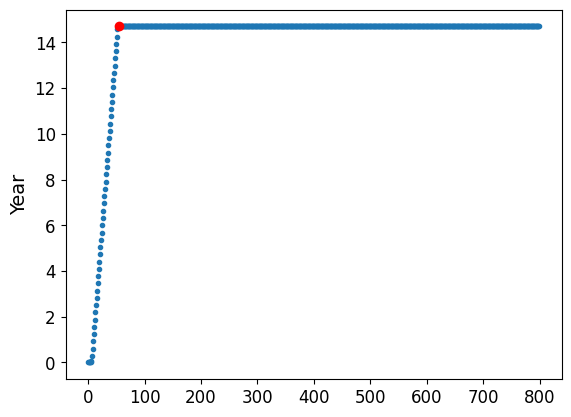

In [14]:
plt.plot( History_Time/Year_in_Second, '.' )

idx_rupture = get_rupture_start_timestep() + 2
print("Rupture time is ", History_Time[idx_rupture]/Year_in_Second, " years")

idx_rupture_External = np.argmin( np.abs(ExternalStress_TimeArray - History_Time[idx_rupture]) ) 

print("Pore pressure is ", 1e-6 * min( NonUniformPorePressureChange[idx_rupture_External] ), "MPa")

plt.plot( idx_rupture, History_Time[idx_rupture]/Year_in_Second,  'ro' )
plt.ylabel('Year')

In [15]:
def get_center_line(faultcenter):
    idx_CLine = np.where(  faultcenter[:,1] == 995. )[0]
    return idx_CLine, faultcenter[idx_CLine]

idx_CenterLine, CenterLine = get_center_line(FaultCenter)

Text(0, 0.5, 'Depth (m)')

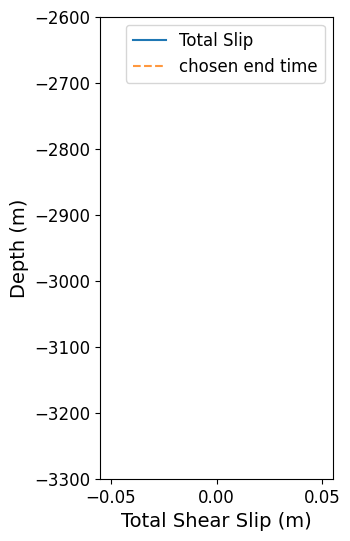

In [16]:
idx_endtime = idx_rupture + 153

def get_time_since_rupture(idx_time):
    nucleation_idx = 80
    return (History_Time[idx_time]-History_Time[idx_rupture+nucleation_idx])

fig = plt.figure(figsize=(3, 6))
ax = fig.add_subplot(111)

ax.plot( History_Disp[-1, idx_CenterLine], -CenterLine[:,2], '-', label=f'Total Slip' )
ax.plot( History_Disp[idx_endtime, idx_CenterLine], -CenterLine[:,2], '--', alpha = 0.8, label=f'chosen end time' )

# ax.plot( TotalSlip[:,0], TotalSlip[:,1], '-', label=f'Fully dynamic simulation')

ax.legend()
ax.set_xscale('linear')
# ax.set_xlim(-1e-4, 0.11)
ax.set_ylim(-3300, -2600)

ax.set_xlabel('Total Shear Slip (m)')
ax.set_ylabel('Depth (m)')

In [17]:
def Calculate_SlipRate(History_Disp, History_Time ):
    SlipRate = np.zeros_like( History_Disp )
    print(SlipRate.shape)
    for i in range(1, len(History_Time) - 1):
        SlipRate[i, :] = ( History_Disp[i+1, :] - History_Disp[i-1, :] ) / (History_Time[i+1] - History_Time[i-1])
    return SlipRate

History_SlipRate = Calculate_SlipRate(History_Disp, History_Time )

(800, 7500)


In [18]:
def Calculate_ShearStress(History_Friction, History_NormalStress ):
    ShearStress = np.zeros_like( History_Disp )
    for i in range(1, len(History_Time)):
        ShearStress[i] = History_Friction[i, :] * History_NormalStress[i, :]
    return ShearStress

History_ShearStress = Calculate_ShearStress(History_Friction, History_NormalStress )

In [19]:
idx_time_MaxSlipRate = np.argmax( np.max(History_SlipRate[ :, idx_CenterLine ], axis = 1) )

fig = plt.figure(figsize=(3, 6))
ax = fig.add_subplot(111)
ax.plot( History_SlipRate[idx_time_MaxSlipRate , idx_CenterLine], -CenterLine[:,2], '-x', label=f'Max slip rate' )
ax.plot( History_SlipRate[idx_endtime , idx_CenterLine], -CenterLine[:,2], '-x', label=f'End Time' )

# ax.plot( MaxSlipRate[:,0], MaxSlipRate[:,1], '-', label=f'Fully dynamic simulation')

ax.legend()
ax.set_xscale('linear')

ax.set_ylim(-3300, -2600)
ax.set_xlim(-1e-3, 2)

ax.set_xlabel('Maximum Slip Rate (m/s)')
ax.set_ylabel('Depth (m)');

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# Find indices where slip transitions from near zero to significant non-zero values
slip_profile = History_Disp[-1, idx_CenterLine]
threshold = 1e-5  # You can adjust this threshold as needed

# Find where slip exceeds the threshold
nonzero_indices = np.where(slip_profile > threshold)[0]

if len(nonzero_indices) > 0:
    idx_top = nonzero_indices[0]
    idx_bottom = nonzero_indices[-1]
    if FaultCenter[idx_CenterLine, 2][idx_top] > FaultCenter[idx_CenterLine, 2][idx_bottom]:
        idx_top, idx_bottom = idx_bottom, idx_top

    tip_top = FaultCenter[idx_CenterLine, 2][idx_top]
    tip_bottom = FaultCenter[idx_CenterLine, 2][idx_bottom]
    print(f"Crack tip top at idx_CenterLine[{idx_top}], depth = {tip_top} m")
    print(f"Crack tip bottom at idx_CenterLine[{idx_bottom}], depth = {tip_bottom} m")
    print(f"Crack tip length = {tip_bottom - tip_top} m")
else:
    print("No significant non-zero slip found.")

Crack tip top at idx_CenterLine[54], depth = 2763.744569986043 m
Crack tip bottom at idx_CenterLine[25], depth = 3036.255430013957 m
Crack tip length = 272.5108600279136 m


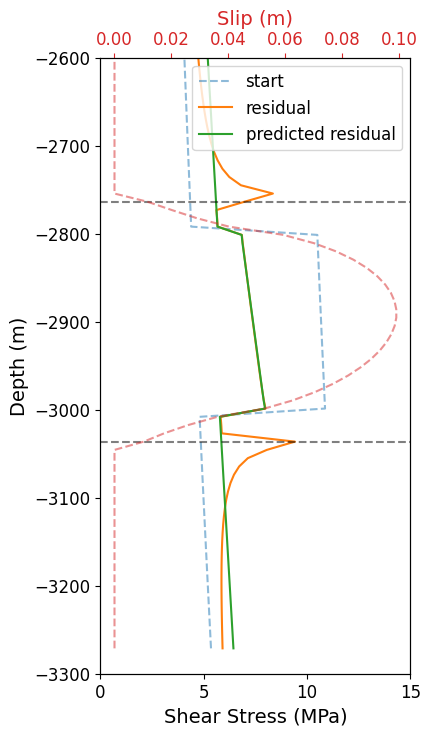

In [ ]:
fig = plt.figure( figsize= (4,8), dpi = 100 )
ax = fig.add_subplot(111)
ax.plot( 1e-6*ExternalStress_Shear[idx_rupture_External, idx_CenterLine], -CenterLine[:,2], '--', alpha = 0.5, label=f'start')
ax.plot( 1e-6*History_ShearStress[idx_endtime, idx_CenterLine], -CenterLine[:,2], '-', label=f'residual')
ax.plot( 0.35 * 1e-6*ExternalStress_Normal[idx_rupture_External, idx_CenterLine], -CenterLine[:,2], '-', label=f'predicted residual')
# ax.plot( ResidualShear[:,0], ResidualShear[:,1], '-', label=f'Fully dynamic end')

ax.legend()
ax.set_xscale('linear')

ax.set_ylim(-3300, -2600)
ax.set_xlim(-1e-3, 15)

ax.set_xlabel('Shear Stress (MPa)')
ax.set_ylabel('Depth (m)');

# crack tips

ax.plot(np.linspace(0, 15, 100), - tip_top * np.ones(100), 'k--', alpha = 0.5)
ax.plot(np.linspace(0, 15, 100), - tip_bottom * np.ones(100), 'k--', alpha = 0.5)

ax2 = ax.twiny()
ax2.plot( History_Disp[-1, idx_CenterLine], -CenterLine[:,2], '--C3', alpha = 0.5, )


ax2.set_xlabel('Slip (m)', color='C3')
ax2.tick_params(axis='x',which='both', colors='C3')


In [ ]:
# Find indices where slip transitions from near zero to significant non-zero values
slip_profile = History_Disp[-1, idx_CenterLine]
threshold = 1e-5  # You can adjust this threshold as needed

# Find where slip exceeds the threshold
nonzero_indices = np.where(slip_profile > threshold)[0]

if len(nonzero_indices) > 0:
    idx_start = nonzero_indices[0]
    idx_end = nonzero_indices[-1]
    print(f"Transition starts at idx_CenterLine[{idx_start}] (index {idx_CenterLine[idx_start]})")
    print(f"Transition ends at idx_CenterLine[{idx_end}] (index {idx_CenterLine[idx_end]})")
else:
    print("No significant non-zero slip found.")

Transition starts at idx_CenterLine[25] (index 7945)
Transition ends at idx_CenterLine[54] (index 7974)


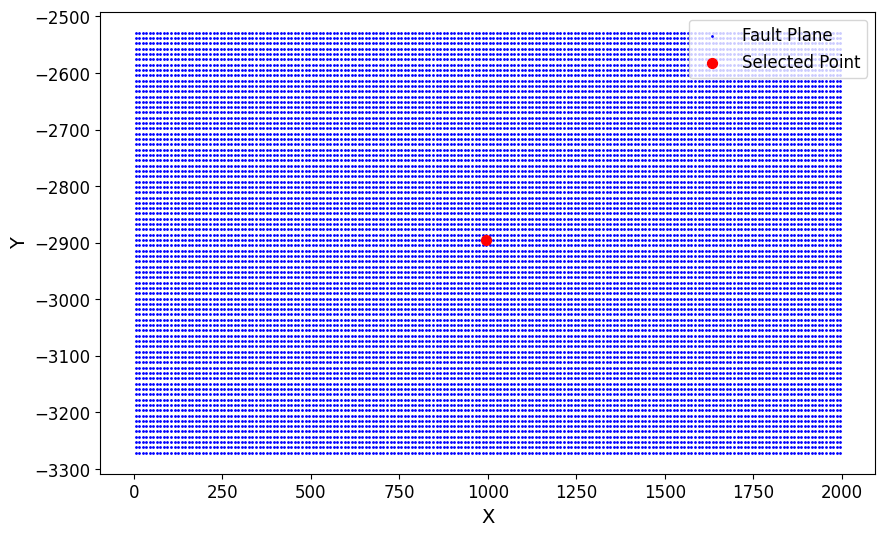

In [ ]:
# Select a point index, for example, the first point in the center line
point_index = idx_CenterLine[40] # 50:2801m 40:~2900m

# Get the coordinates of the selected point
point_coordinates = FaultCenter[point_index]

# Plot the fault plane and the selected point
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot( 111 )

# Plot the fault plane
ax.scatter(FaultCenter[:, 1], -FaultCenter[:, 2], s=1, c='b', label='Fault Plane')

# Plot the selected point
ax.scatter(point_coordinates[1], -point_coordinates[2], s=50, c='r', label='Selected Point')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
plt.show()

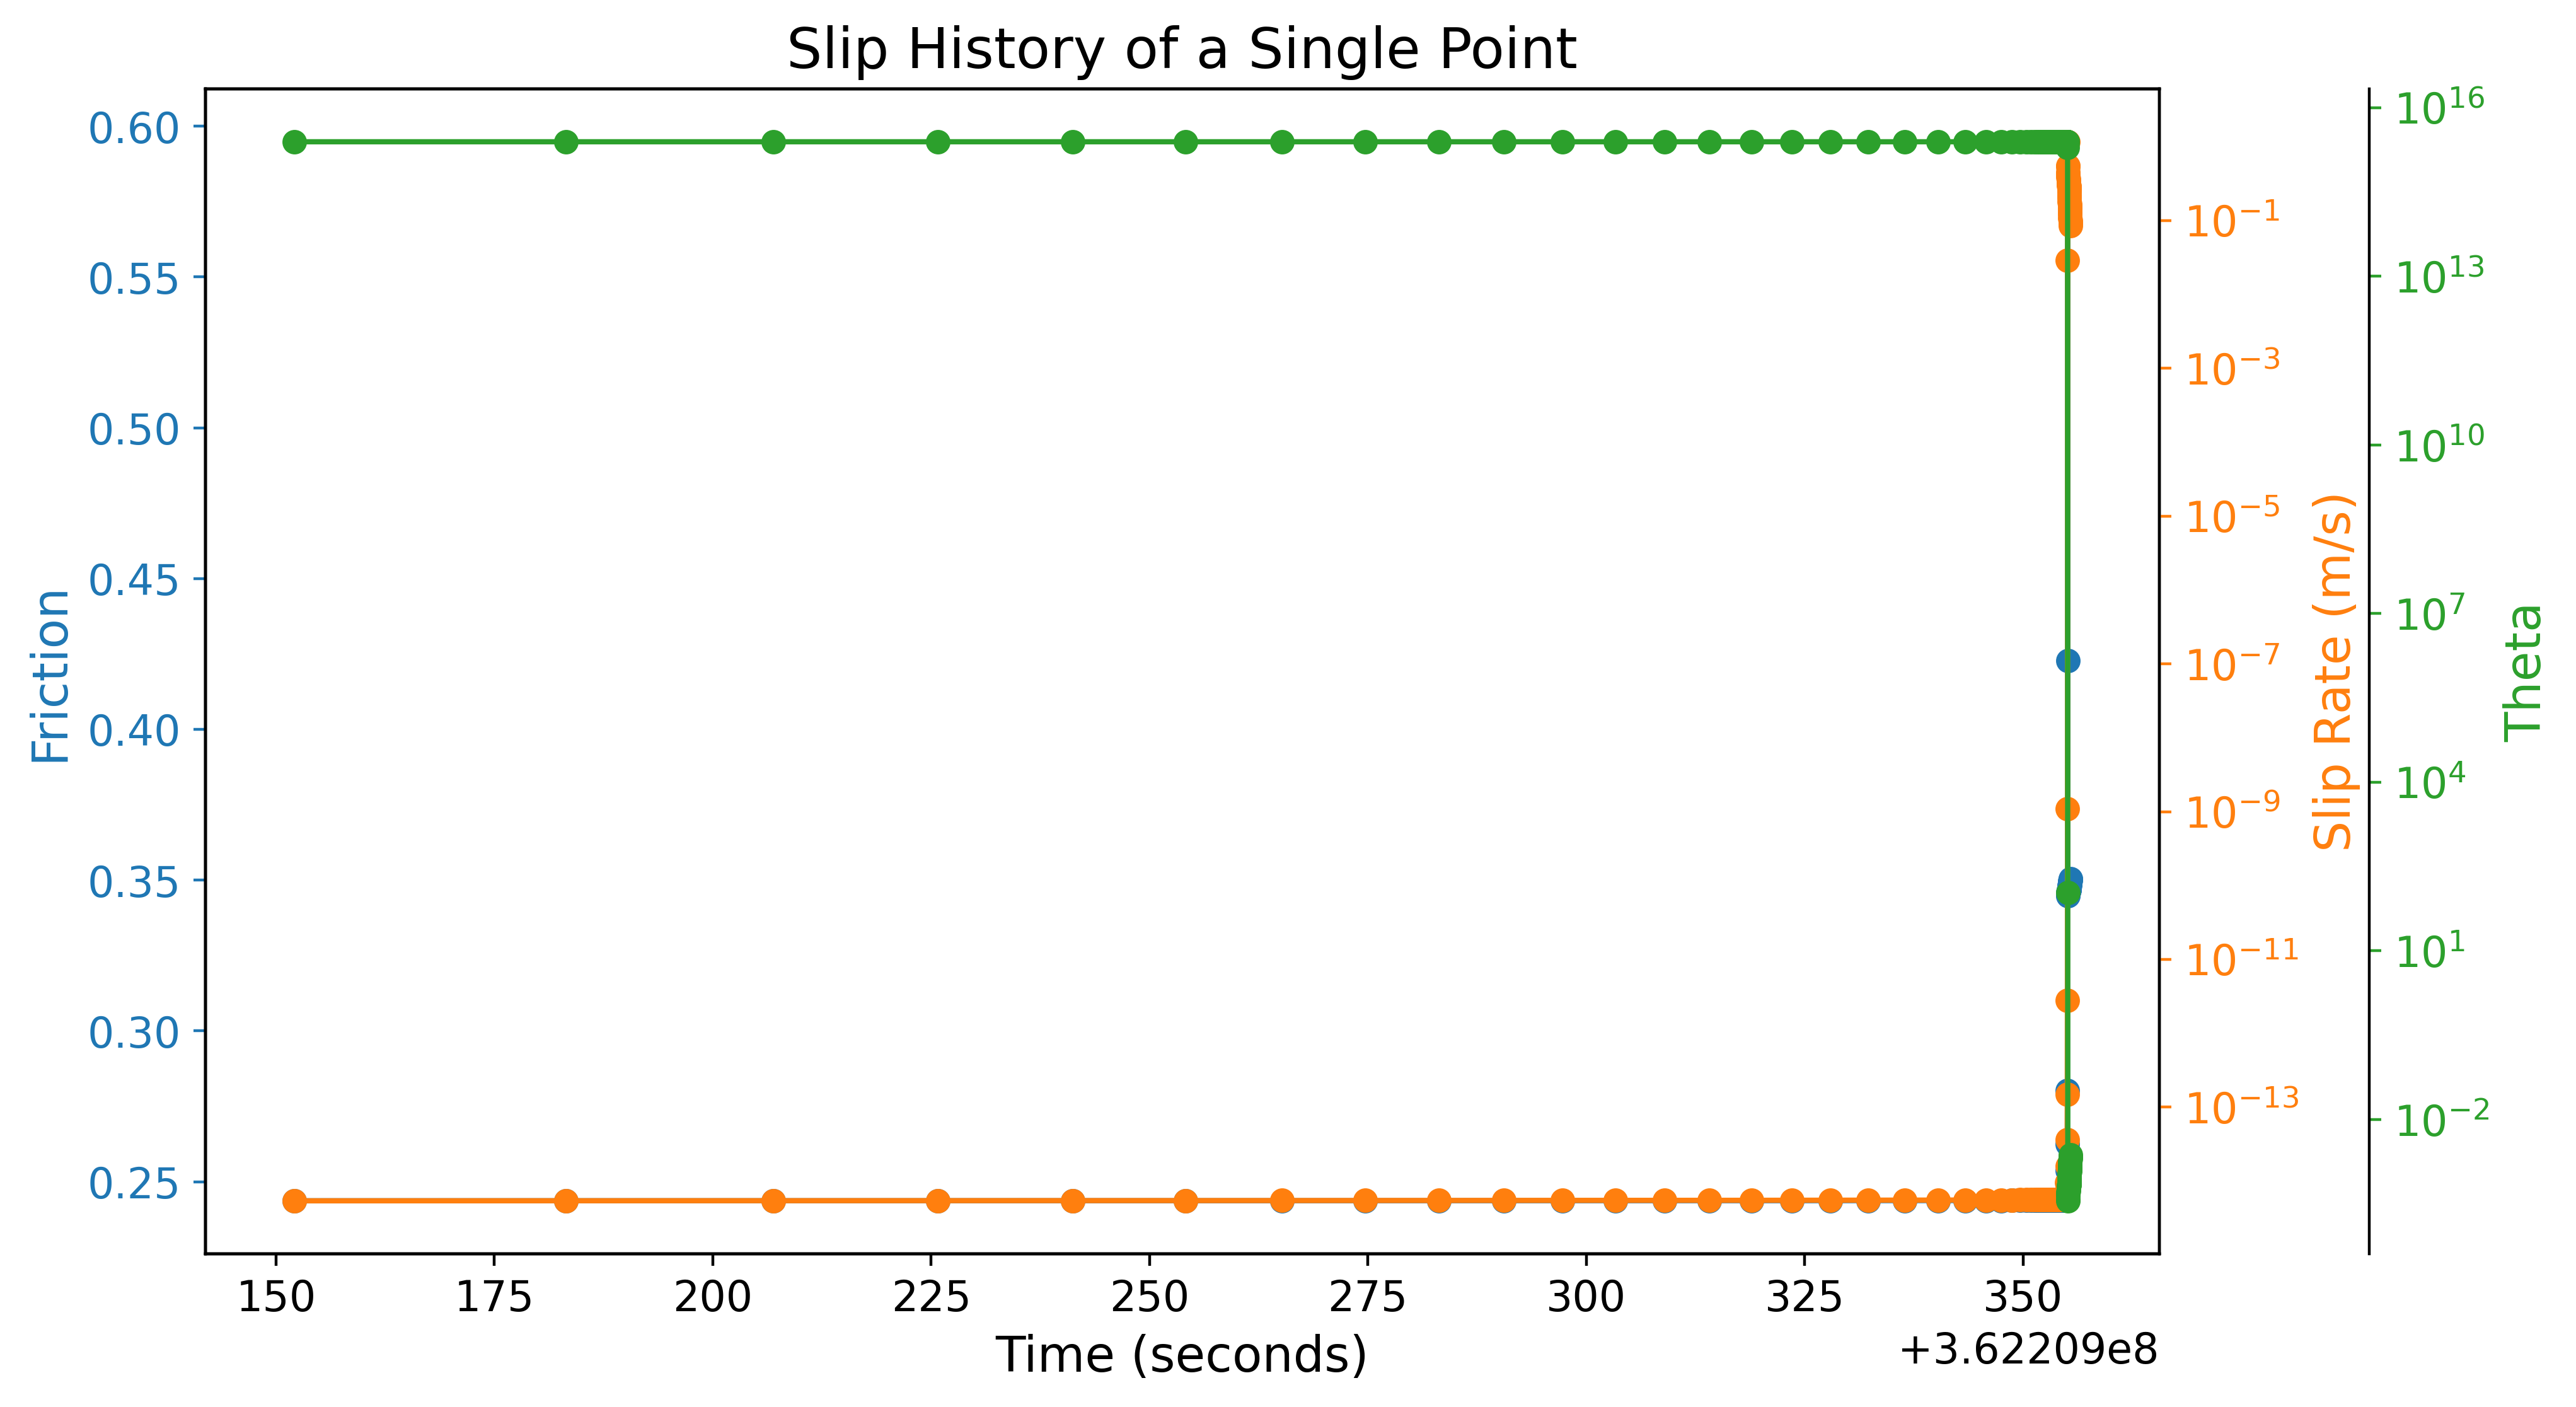

In [ ]:
idx_rupture2 = idx_rupture

fig = plt.figure(figsize=(10, 6), dpi = 400)
ax = fig.add_subplot(111)
ax.plot(History_Time[idx_rupture2:], History_Friction[idx_rupture2:, point_index], 'o-',label='our simulations' )


# TimeIdx_peak = np.argmax(History_Friction[:, point_index])
# peak_slip     = History_Disp[TimeIdx_peak, point_index]
# peak_friction = History_Friction[TimeIdx_peak, point_index]

# ax.plot([ peak_slip, peak_slip + Dc, History_Disp[-1, point_index] ],[ fs, fr, fr ],'C0--',label='Slip weakening')

ax.set_xlabel('Time (seconds)')
ax.set_title(f'Slip History of a Single Point')

ax.set_ylabel('Friction')
ax.tick_params(axis='y',which='both', colors='C0')
ax.set_ylabel("Friction", color='C0' )

ax2 = ax.twinx()
ax2.plot(History_Time[idx_rupture2:], History_V[idx_rupture2:, point_index], 'C1o-'  )
ax2.tick_params(axis='y',which='both', colors='C1')
ax2.set_ylabel('Slip Rate (m/s)', color='C1' )
ax2.set_yscale('log')

ax3 = ax.twinx()
ax3.spines['right'].set_position( ('outward', 60) )
ax3.plot(History_Time[idx_rupture2:], History_Theta[idx_rupture2:, point_index], 'C2o-'  )
ax3.tick_params(axis='y',which='both', colors='C2')
ax3.set_ylabel("Theta", color='C2' )
ax3.set_yscale('log')


Dc =  8.333333333333336  mm


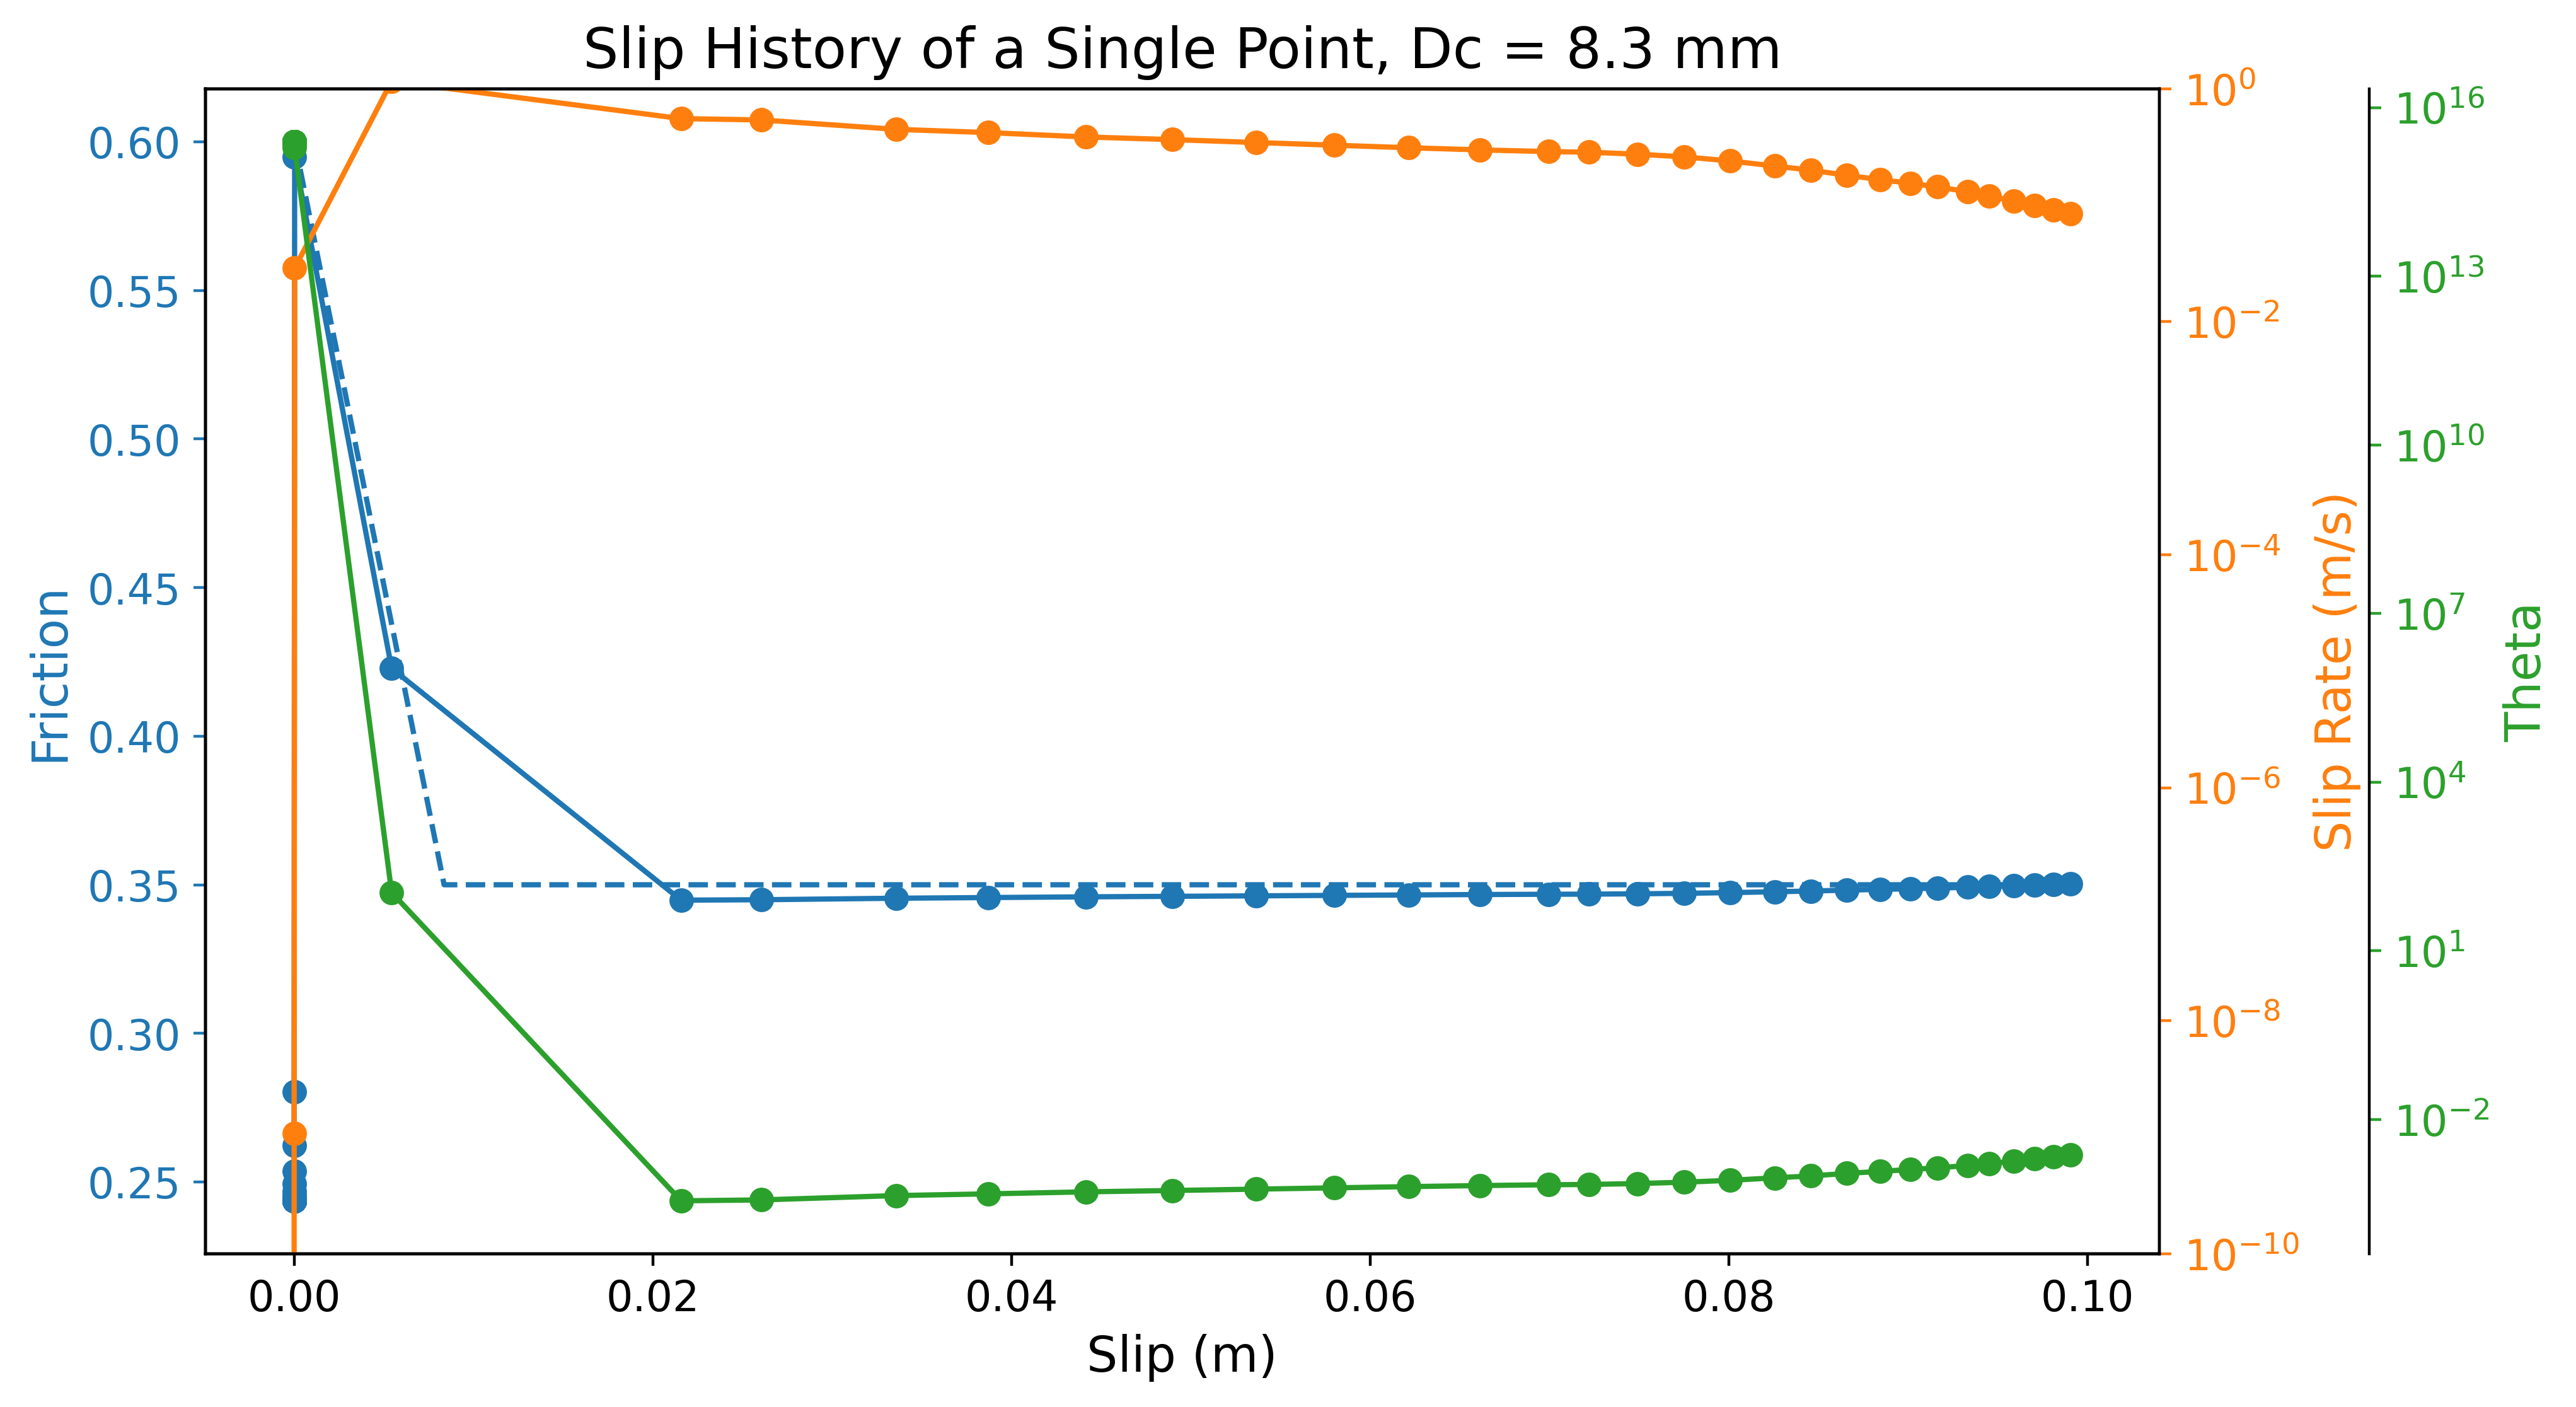

In [ ]:
# Plot the slip history for the selected point
fs = 0.6
fr = 0.35
W = 0.03  # unit:mm^-1

# Dc = 5*1e-3 
Dc = (fs-fr)/W*1e-3 # meter
print("Dc = ", Dc*1e3, " mm")

fig = plt.figure(figsize=(10, 6), dpi = 400)
ax = fig.add_subplot(111)
ax.plot(History_Disp[idx_rupture:, point_index], History_Friction[idx_rupture:, point_index], 'o-',label='our simulations' )


TimeIdx_peak = np.argmax(History_Friction[:, point_index])
peak_slip     = History_Disp[TimeIdx_peak, point_index]
peak_friction = History_Friction[TimeIdx_peak, point_index]

ax.plot([ peak_slip, peak_slip + Dc, History_Disp[-1, point_index] ],[ fs, fr, fr ],'C0--',label='Slip weakening')

ax.set_xlabel('Slip (m)')
ax.set_ylabel('Friction')
ax.set_title(f'Slip History of a Single Point, Dc = {Dc*1e3:.1f} mm')
ax.tick_params(axis='y',which='both', colors='C0')
ax.set_ylabel("Friction", color='C0' )

ax2 = ax.twinx()
ax2.plot(History_Disp[idx_rupture:, point_index], History_V[idx_rupture:, point_index], 'C1o-'  )
ax2.tick_params(axis='y',which='both', colors='C1')
ax2.set_ylim([1e-10,1])
ax2.set_ylabel('Slip Rate (m/s)', color='C1' )
ax2.set_yscale('log')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(History_Disp[idx_rupture:, point_index], History_Theta[idx_rupture:, point_index], 'C2o-'  )
ax3.tick_params(axis='y',which='both', colors='C2')
ax3.set_ylabel("Theta", color='C2' )
ax3.set_yscale('log')
